# Compare autoarima from Skforecast, pmdarima and statsforecast

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)
import skforecast

print(skforecast.__version__)

/home/joaquin/Documents/GitHub/skforecast
0.20.0


In [ ]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from skforecast.stats import Arima
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
import warnings
import timeit

In [ ]:
# Datasets
# ==============================================================================
from fixtures_arima import datasets

In [4]:
# Benchmarking ARIMA implementations
# ==============================================================================
warnings.filterwarnings("ignore", message=".*force_all_finite.*")
warnings.filterwarnings("ignore", message=".*Non-stationary starting seasonal autoregressive.*")
warnings.filterwarnings("ignore", message=".*Too few observations to estimate starting parameters.*")
warnings.filterwarnings("ignore", message=".*Too few observations to estimate starting parameters for seasonal ARMA.*")

results = []
for key, value in datasets.items():
    data = value['data']
    m = value['seasonal_periods']
    name = key
    print(f"Dataset: {name}")

    # pmdarima
    try:
        print("    pmdarima...")
        start = timeit.default_timer()
        res = auto_arima(
            y=data,
            start_p=0,
            start_q=0,
            max_p=3,
            max_q=3,
            max_P=2,
            max_D=1,
            max_Q=2,
            seasonal=True,
            information_criterion="aic",
            test="kpss",
            m=m,
            d=None,
            D=None,
            trace=False,
            n_fits=94,
            method="bfgs",
            maxiter=500,
            error_action="ignore",
            suppress_warnings=True,
            stepwise=True,
        )
        end = timeit.default_timer()
        elapsed_time = end - start
        best_model = f"{res.order}{res.seasonal_order[:3]}[{res.seasonal_order[3]}]"
        aic = res.aic()
    except Exception as e:
        elapsed_time = np.nan
        best_model = "(nan, nan, nan)(nan, nan, nan)[nan]"
        aic = np.nan
    results.append([name, "pmdarima", best_model, aic, elapsed_time])
    print(f"        time: {elapsed_time:.2f} seconds")
    print(f"        best model: {best_model}")

    # skforecast
    print("    skforecast...")
    try:
        start = timeit.default_timer()
        res = Arima(
            order=None,
            seasonal_order=None,
            start_p=0,
            start_q=0,
            max_p=3,
            max_q=3,
            max_P=2,
            max_Q=2,
            max_order=5,
            max_d=2,
            max_D=1,
            ic="aic",
            seasonal=True,
            test="kpss",
            nmodels=94,
            optim_method="BFGS",
            m=m,
            trace=False,
            stepwise=True,
        )
        res.fit(y=data, suppress_warnings=True)
        end = timeit.default_timer()
        elapsed_time = end - start
        best_model = f"{res.best_params_['order']}{res.best_params_['seasonal_order']}[{res.best_params_['m']}]"
        aic = res.aic_
    except Exception as e:
        elapsed_time = np.nan
        best_model = "(nan, nan, nan)(nan, nan, nan)[nan]"
        aic = np.nan
    results.append([name, "skforecast", best_model, aic, elapsed_time])
    print(f"        time: {elapsed_time:.2f} seconds")
    print(f"        best model: {best_model}")

    # statsforecast
    print("    statsforecast...")
    try:
        start = timeit.default_timer()
        res = AutoARIMA(
            start_p=0,
            start_q=0,
            max_p=3,
            max_q=3,
            max_P=2,
            max_D=1,
            max_Q=2,
            nmodels=94,
            test="kpss",
            ic="aic",
            d=None,
            D=None,
            seasonal=True,
            season_length=m,
            stepwise=True,
            trace=False,
        )
        res.fit(y=data)
        end = timeit.default_timer()
        elapsed_time = end - start
        best_model = arima_string(res.model_)[5:].replace(",", ", ")
        aic = res.model_['aic']
    except Exception as e:
        elapsed_time = np.nan
        best_model = "(nan, nan, nan)(nan, nan, nan)[nan]"
        aic = np.nan
    results.append([name, "statsforecast", best_model, aic, elapsed_time])
    print(f"        time: {elapsed_time:.2f} seconds")
    print(f"        best model: {best_model}")

Dataset: air_passengers
    pmdarima...
        time: 46.13 seconds
        best model: (0, 1, 1)(2, 1, 1)[12]
    skforecast...
        time: 2.41 seconds
        best model: (2, 1, 1)(0, 1, 0)[12]
    statsforecast...
        time: 0.38 seconds
        best model: (1, 1, 0)(0, 1, 0)[12]                   
Dataset: monthly_data
    pmdarima...
        time: 1.16 seconds
        best model: (0, 0, 0)(0, 1, 0)[12]
    skforecast...
        time: 0.41 seconds
        best model: (0, 0, 0)(0, 1, 0)[12]
    statsforecast...
        time: 0.32 seconds
        best model: (0, 0, 0)(0, 1, 0)[12]                   
Dataset: quarterly_data
    pmdarima...
        time: 2.38 seconds
        best model: (0, 0, 0)(0, 1, 1)[4]
    skforecast...
        time: 0.29 seconds
        best model: (0, 0, 0)(0, 1, 1)[4]
    statsforecast...
        time: 0.71 seconds
        best model: (0, 0, 0)(0, 1, 1)[4]                   
Dataset: daily_data
    pmdarima...
        time: 6.30 seconds
        best mode

In [5]:
# Results
# ==============================================================================
results_df = pd.DataFrame(
    results,
    columns=["dataset", "library", "Best Model", "AIC", "Time"]
)
results_df['Best Model'] = results_df['Best Model'].str.replace(', ', ',').str.strip()
results_df = results_df.set_index(['dataset'])
results_df['All_Same_Model'] = results_df.groupby('dataset')['Best Model'].transform(lambda x: x.nunique() == 1)
results_df

,library,Best Model,AIC,Time,All_Same_Model
dataset,,,,,
air_passengers,pmdarima,"(0,1,1)(2,1,1)[12]",1018.243685,46.129013,False
air_passengers,skforecast,"(2,1,1)(0,1,0)[12]",1018.181537,2.411985,False
air_passengers,statsforecast,"(1,1,0)(0,1,0)[12]",1020.394372,0.382021,False
monthly_data,pmdarima,"(0,0,0)(0,1,0)[12]",201.117107,1.155418,True
monthly_data,skforecast,"(0,0,0)(0,1,0)[12]",201.805756,0.405179,True
monthly_data,statsforecast,"(0,0,0)(0,1,0)[12]",201.117107,0.319006,True
quarterly_data,pmdarima,"(0,0,0)(0,1,1)[4]",153.509042,2.378447,True
quarterly_data,skforecast,"(0,0,0)(0,1,1)[4]",154.527856,0.287871,True
quarterly_data,statsforecast,"(0,0,0)(0,1,1)[4]",153.554007,0.709958,True


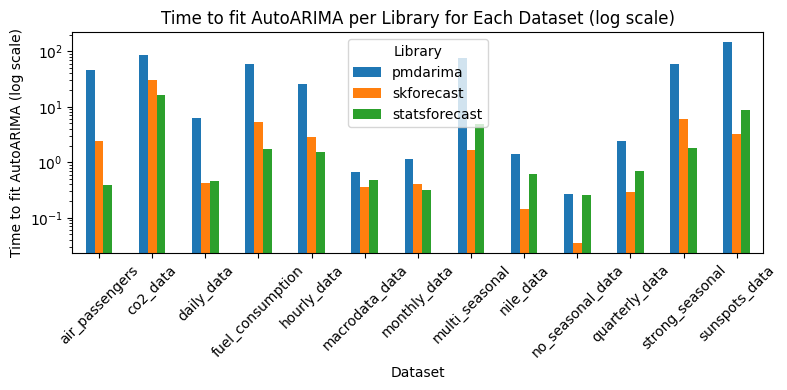

In [9]:
# Plot searching times
# ==============================================================================
from matplotlib import pyplot as plt

df_plot = results_df.pivot(columns="library", values="Time")
ax = df_plot.plot(kind="bar", figsize=(8,4))
plt.yscale("log") 
ax.set_ylabel("Time to fit AutoARIMA (log scale)")
ax.set_xlabel("Dataset")
plt.title("Time to fit AutoARIMA per Library for Each Dataset (log scale)")
plt.xticks(rotation=45)
plt.legend(title="Library")
plt.tight_layout()
plt.show()

In [10]:
# Number of datasets where skforecast and statsforecast found the same best model
# ==============================================================================
results_skforecast_statsforecast = (
    results_df
    .query("library in ['skforecast', 'statsforecast']")
).copy()
results_skforecast_statsforecast['All_Same_Model'] = (
    results_skforecast_statsforecast
    .groupby('dataset')['Best Model']
    .transform(lambda x: x.nunique() == 1)
)
n_same_model = results_skforecast_statsforecast.groupby('dataset')['All_Same_Model'].first().sum()
print(f"Number of datasets where skforecast and statsforecast found the same best model: {n_same_model} out of {len(datasets)}")
results_skforecast_statsforecast

Number of datasets where skforecast and statsforecast found the same best model: 3 out of 13


,library,Best Model,AIC,Time,All_Same_Model
dataset,,,,,
air_passengers,skforecast,"(2,1,1)(0,1,0)[12]",1018.181537,2.411985,False
air_passengers,statsforecast,"(1,1,0)(0,1,0)[12]",1020.394372,0.382021,False
monthly_data,skforecast,"(0,0,0)(0,1,0)[12]",201.805756,0.405179,True
monthly_data,statsforecast,"(0,0,0)(0,1,0)[12]",201.117107,0.319006,True
quarterly_data,skforecast,"(0,0,0)(0,1,1)[4]",154.527856,0.287871,True
quarterly_data,statsforecast,"(0,0,0)(0,1,1)[4]",153.554007,0.709958,True
daily_data,skforecast,"(0,0,0)(1,1,0)[7]",364.390365,0.418797,False
daily_data,statsforecast,"(0,0,0)(0,1,1)[7]",363.976210,0.451596,False
hourly_data,skforecast,"(1,0,0)(0,1,0)[24]",565.001565,2.881394,False


In [8]:
# Number of datasets where skforecast and pmdarima found the same best model
# ==============================================================================
results_skforecast_pdmarima = (
    results_df
    .query("library in ['skforecast', 'pmdarima']")
).copy()
results_skforecast_pdmarima['All_Same_Model'] = (
    results_skforecast_pdmarima
    .groupby('dataset')['Best Model']
    .transform(lambda x: x.nunique() == 1)
)
n_same_model = results_skforecast_pdmarima.groupby('dataset')['All_Same_Model'].first().sum()
print(f"Number of datasets where skforecast and pmdarima found the same best model: {n_same_model} out of {len(datasets)}")
results_skforecast_pdmarima

Number of datasets where skforecast and pmdarima found the same best model: 5 out of 13


,library,Best Model,AIC,Time,All_Same_Model
dataset,,,,,
air_passengers,pmdarima,"(0,1,1)(2,1,1)[12]",1018.243685,46.129013,False
air_passengers,skforecast,"(2,1,1)(0,1,0)[12]",1018.181537,2.411985,False
monthly_data,pmdarima,"(0,0,0)(0,1,0)[12]",201.117107,1.155418,True
monthly_data,skforecast,"(0,0,0)(0,1,0)[12]",201.805756,0.405179,True
quarterly_data,pmdarima,"(0,0,0)(0,1,1)[4]",153.509042,2.378447,True
quarterly_data,skforecast,"(0,0,0)(0,1,1)[4]",154.527856,0.287871,True
daily_data,pmdarima,"(0,0,0)(1,1,0)[7]",363.314420,6.299636,True
daily_data,skforecast,"(0,0,0)(1,1,0)[7]",364.390365,0.418797,True
hourly_data,pmdarima,"(1,0,0)(1,0,0)[24]",777.407703,25.888219,False
